## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [31]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [28]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_w):
    """Define the customized loss."""
    def focal_loss(gamma=2., alpha=4.):
        gamma = float(gamma)
        alpha = float(alpha)
        def focal_loss_fixed(y_true, y_pred):
            """Focal loss for multi-classification
            FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
            """
            epsilon = 1e-8
            y_true = tf.convert_to_tensor(y_true, tf.float32)
            y_pred = tf.convert_to_tensor(y_pred, tf.float32)

            model_out = tf.add(y_pred, epsilon)
            ce = tf.multiply(y_true, -tf.log(model_out))
            weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
            fl = tf.multiply(alpha, tf.multiply(weight, ce))
            reduced_fl = tf.reduce_max(fl, axis=1)
            return (1-ce_w)*tf.reduce_mean(reduced_fl) + ce_w*tf.reduce_mean(ce)
        return focal_loss_fixed
    return focal_loss()

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [32]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss=combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s-ce_w-%.2f" % (i,ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_47 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_48 (Batc (None, 128) 

Epoch 14/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.7118 - acc: 0.6496 - val_loss: 2.8797 - val_acc: 0.4798
Epoch 15/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.6476 - acc: 0.6593 - val_loss: 2.9071 - val_acc: 0.4778
Epoch 16/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.5653 - acc: 0.6725 - val_loss: 2.8842 - val_acc: 0.4867
Epoch 17/25
50000/50000 [==============================] - 2s 42us/step - loss: 1.4820 - acc: 0.6882 - val_loss: 2.8817 - val_acc: 0.4884
Epoch 18/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4136 - acc: 0.6999 - val_loss: 2.9266 - val_acc: 0.4812
Epoch 19/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3461 - acc: 0.7122 - val_loss: 2.9363 - val_acc: 0.4887
Epoch 20/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2731 - acc: 0.7234 - val_loss: 2.9661 - val_acc: 0.4891
Epoch 21/25
50000/50000 [=========

Epoch 2/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.5989 - acc: 0.3999 - val_loss: 1.7138 - val_acc: 0.3750
Epoch 3/25
50000/50000 [==============================] - 2s 41us/step - loss: 1.4474 - acc: 0.4423 - val_loss: 1.5362 - val_acc: 0.4064
Epoch 4/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.3585 - acc: 0.4675 - val_loss: 1.4856 - val_acc: 0.4249
Epoch 5/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2937 - acc: 0.4859 - val_loss: 1.4436 - val_acc: 0.4418
Epoch 6/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.2393 - acc: 0.5040 - val_loss: 1.4277 - val_acc: 0.4392
Epoch 7/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.1923 - acc: 0.5192 - val_loss: 1.4037 - val_acc: 0.4482
Epoch 8/25
50000/50000 [==============================] - 2s 40us/step - loss: 1.1502 - acc: 0.5317 - val_loss: 1.3736 - val_acc: 0.4540
Epoch 9/25
50000/50000 [=================

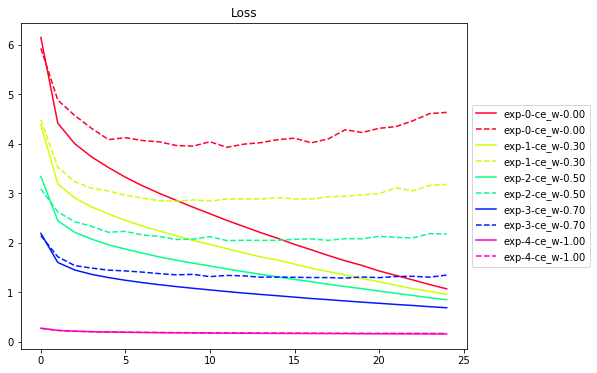

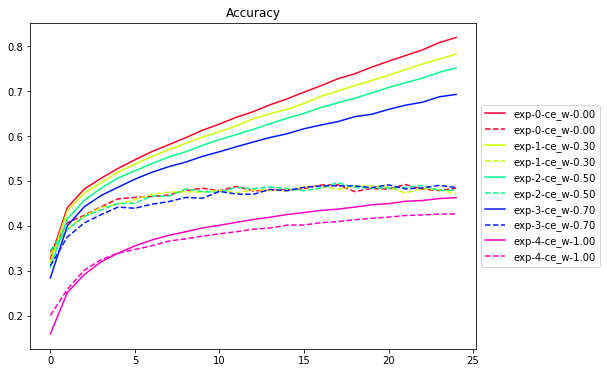

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()